# Downloading dataset

I have downloaded the dataset manually and uploaded it in the input section of kaggle notebook.

Dataset can be downloaded here: https://storage.googleapis.com/wandb_datasets/nature_12K.zip

# Part A: Training from scratch

## Question 1

### computing the shape of input images, so that we can design CNN accordingly

In [1]:
from PIL import Image
import numpy as np

img_1 = Image.open('/kaggle/input/inaturalist-12k/inaturalist_12K/train/Amphibia/0012ec13b97dfbfb3dd5de8c3da95555.jpg')

img_array = np.array(img_1)

print(f'shape of input image is {img_array.shape}')

shape of input image is (600, 800, 3)


### Building 5 layer CNN model 

In [2]:
# Importing libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import wandb
import torchvision.transforms as T
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

In [3]:

# Building a class for CNN model
class CNNLightningModel(pl.LightningModule):
    def __init__(
        self,
        input_size=(600, 800, 3),
        num_classes=10,
        conv_channels=[16, 32, 64, 64, 64],
        kernel_sizes=[3, 3, 3, 3, 3],
        activation_fn="ReLU",
        dense_neurons=512,
        max_pool_size=2,
        learning_rate=1e-3,
        batch_norm=False,
        dropout=0.2,
    ):
        super(CNNLightningModel, self).__init__()
        self.save_hyperparameters()
        # Map activation function
        activation_map = {
            "ReLU": nn.ReLU,
            "GELU": nn.GELU,
            "SiLU": nn.SiLU,
            "Mish": nn.Mish,
        }
        act_fn = activation_map[activation_fn]
        self.act_fn = act_fn()
        
        self.conv_layers = nn.ModuleList()
        in_channels = input_size[2]
        for out_channels, kernel_size in zip(conv_channels, kernel_sizes):
            layers = [
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=kernel_size,
                    padding=kernel_size // 2,
                )
            ]
            if batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(act_fn())
            layers.append(nn.MaxPool2d(kernel_size=max_pool_size))
            if dropout > 0:
                layers.append(nn.Dropout2d(dropout/2))  # Lower dropout for conv layers
            self.conv_layers.append(nn.Sequential(*layers))
            in_channels = out_channels
            
        # Calculate flattened size
        height, width = input_size[0], input_size[1]
        for _ in range(len(conv_channels)):
            height //= max_pool_size
            width //= max_pool_size
        flatten_size = conv_channels[-1] * height * width
        
        self.fc1 = nn.Linear(flatten_size, dense_neurons)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(dense_neurons, num_classes)
        self.learning_rate = learning_rate
        self.loss_fn = nn.CrossEntropyLoss()
        
    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        x = self.act_fn(self.fc1(x))
        x = self.dropout(x)
        return self.fc_out(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True, logger=True)
        return {"val_loss": loss, "val_acc": acc}
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=2, verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss"
        }

In [4]:
model = CNNLightningModel(batch_norm=True, activation_fn="GELU")

print(model)

CNNLightningModel(
  (act_fn): GELU(approximate='none')
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.1, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.1, inplace=False)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

## Question 2

In [5]:
# importing libraries

import os
import shutil
from sklearn.model_selection import train_test_split

In [6]:
data_dir = '/kaggle/input/inaturalist-12k/inaturalist_12K/train'
new_val_dir = 'val_for_tuning'
new_train_dir = 'train_for_tuning'
os.makedirs(new_val_dir, exist_ok=True)
os.makedirs(new_train_dir, exist_ok=True)

In [7]:
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir,class_name)

    # error handling in case the class_path does not exist
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    train_imgs, val_imgs = train_test_split(images,test_size=0.2, random_state=42)

    # create a new directory for storing val_imgs
    os.makedirs(os.path.join(new_val_dir, class_name), exist_ok = True)
    os.makedirs(os.path.join(new_train_dir, class_name), exist_ok = True)

    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(new_val_dir, class_name, img))

    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(new_train_dir, class_name, img))

The above code will create two folders inside output directory of kaggle as follows
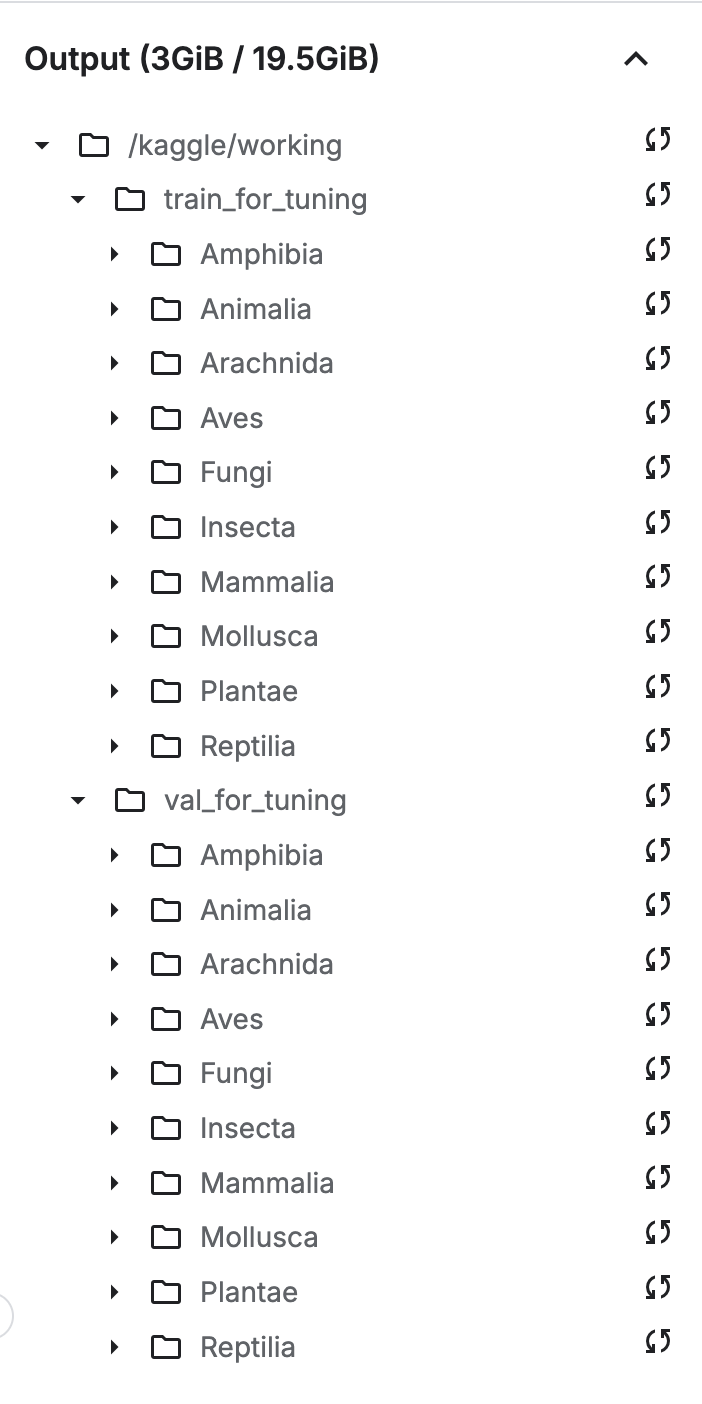
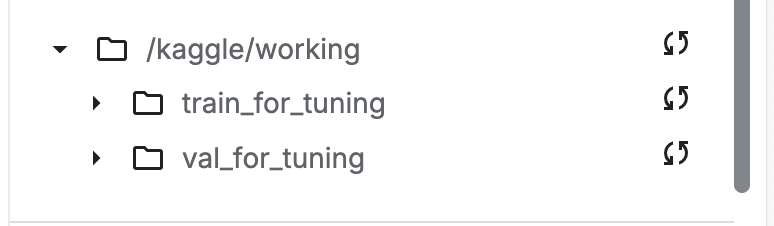

In [8]:
# storing wandb api key in secrets

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api")

In [9]:
# setting up wandb

!pip -q install wandb --upgrade
import wandb
wandb.login(key=secret_value_0)

print(wandb.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 90.4 MB/s eta 0:00:00:00:0100:01


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24m007 (da24m007-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


0.19.6


In [10]:
# Set up wandb logger with python lightning

from pytorch_lightning.loggers import WandbLogger

wandb_logger = WandbLogger(project='DL-A2-V2')

In [11]:
# Data augmentation transforms
def get_transforms(data_augmentation=False):
    IMAGE_SIZE = (224, 224) 
    if data_augmentation:
        return T.Compose([
            T.Resize(IMAGE_SIZE),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(degrees=15),
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            T.ToTensor(),
            T.Normalize(mean=[0.5]*3, std=[0.5]*3)  # normalize to [-1, 1]
        ])
    return T.Compose([
        T.Resize(IMAGE_SIZE),
        T.ToTensor(),
        T.Normalize(mean=[0.5]*3, std=[0.5]*3)  # normalize to [-1, 1]
    ])

In [12]:
# Training function for sweep

def train_sweep():
    run = wandb.init()
    config = wandb.config

    print(config)

    # Datasets
    train_dataset = datasets.ImageFolder(root=new_train_dir, transform=get_transforms(bool(config.data_augmentation)))
    val_dataset = datasets.ImageFolder(root=new_val_dir, transform=get_transforms(bool(config.data_augmentation)))

    # Dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)
    val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)

    # Initialize model
    model = CNNLightningModel(
        input_size=(224, 224, 3),
        conv_channels=config.conv_channels,
        kernel_sizes=[3] * len(config.conv_channels),
        activation_fn=config.activation_fn,
        dense_neurons=512,
        max_pool_size=2,
        learning_rate=config.learning_rate,
        batch_norm=config.batch_norm,
        dropout=config.dropout,
    )

    # W&B logger
    wandb_logger = WandbLogger(log_model=False)

    # Callback to save best model based on val_acc
    checkpoint_callback = ModelCheckpoint(
        monitor="val_acc",               # Must match your `log()` key in validation step
        filename="best-model",          # Saves as "best-model.ckpt"
        save_top_k=1,
        mode="max",
        save_weights_only=False
    )

    # Trainer
    trainer = pl.Trainer(
        max_epochs=10,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        logger=wandb_logger,
        callbacks=[checkpoint_callback],
    )

    # Train
    trainer.fit(model, train_dataloader, val_dataloader)

    # Log the best model checkpoint as W&B artifact
    best_model_path = checkpoint_callback.best_model_path

    if best_model_path:
        artifact = wandb.Artifact("best-cnn-model", type="model")
        artifact.add_file(best_model_path)

        # Optionally include val_acc in metadata
        val_acc = wandb_logger.experiment.summary.get("val_acc")
        if val_acc is not None:
            artifact.metadata = {"val_acc": val_acc}

        run.log_artifact(artifact)

    run.finish()

# Sweep configuration
sweep_config = {
    "method": "bayes",
    "metric": {"name": "val_acc", "goal": "maximize"},
    "parameters": {
        "conv_channels": {
            "values": [
                [32, 32, 32,32,32],
                [64, 64, 64,64,64],
                [16, 32, 64,128,256],
                [32, 64, 128, 64, 32],
                [256, 128, 64, 32, 16],  # Halving channels
                [32, 64, 64, 128, 128], 
                [16, 64, 128, 256, 256],  # Doubling channels
                [256, 128, 64, 32, 32]   # Decreasing channels
            ]
        },
        "activation_fn": {"values": ["ReLU", "GELU", "SiLU", "Mish"]},
        "data_augmentation": {"values": [True, False]},
        "batch_norm": {"values": [True, False]},
        "dropout": {"values": [0.0, 0.2, 0.3, 0.4]},
        "learning_rate": {"distribution": "log_uniform_values", "min": 1e-4, "max": 1e-2},
        "batch_size": {"values": [16, 32, 64]},
    },
}

In [ ]:
# Initialize and run sweep
sweep_id = wandb.sweep(sweep_config, project = 'DL-A2-V2')
wandb.agent(sweep_id, function=train_sweep, count=20) 

## Loading best performing model for prediction

In [13]:
import os

# Initialize W&B API
api = wandb.Api()

# Replace with your actual values
entity = "da24m007-iit-madras"
project = "DL-A2-V2"
artifact_name = "best-cnn-model"

# Get all versions of the model artifact
artifact_versions = api.artifact_versions(
    type_name="model",
    name=f"{entity}/{project}/{artifact_name}"
)

# Store artifact and val_acc
artifact_scores = []

for artifact in artifact_versions:
    val_acc = artifact.metadata.get("val_acc", None)
    if val_acc is not None:
        artifact_scores.append((val_acc, artifact))

# Sort artifacts by val_acc
artifact_scores.sort(key=lambda x: x[0], reverse=True)

if len(artifact_scores) == 0:
    print("❌ No artifacts found with val_acc in metadata.")
else:
    # Best one
    best_val_acc, best_artifact = artifact_scores[0]
    print(f"✅ Best model: {best_artifact.name} with val_acc = {best_val_acc}")

    # Download it
    best_model_dir = best_artifact.download()
    ckpt_path = os.path.join(best_model_dir, "best-model.ckpt")

    # Load it
    model = CNNLightningModel.load_from_checkpoint(ckpt_path)
   

    print("🎯 Model loaded and ready for prediction!")

wandb: WARNING Api.artifact_versions(type_name, name) is deprecated, use Api.artifacts(type_name, name) instead.
wandb: Downloading large artifact best-cnn-model:v29, 84.71MB. 1 files... 


✅ Best model: best-cnn-model:v29 with val_acc = 0.4020000100135803


wandb:   1 of 1 files downloaded.  
Done. 0:0:1.7


🎯 Model loaded and ready for prediction!


In [14]:
model

CNNLightningModel(
  (act_fn): Mish()
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Mish()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Mish()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Mish()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Con

## Preparing test data

In [22]:
# Test transform (no augmentation, just resize and normalize)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_dataset = datasets.ImageFolder(root="/kaggle/input/inaturalist-12k/inaturalist_12K/val", transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Get class names
class_names = test_dataset.classes

In [21]:
import torch
from sklearn.metrics import accuracy_score

all_preds = []
all_labels = []

model.eval()
device = next(model.parameters()).device  # Get model's device

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = accuracy_score(all_labels, all_preds)
print(f"✅ Test Accuracy: {test_acc:.4f}")


✅ Test Accuracy: 0.1880


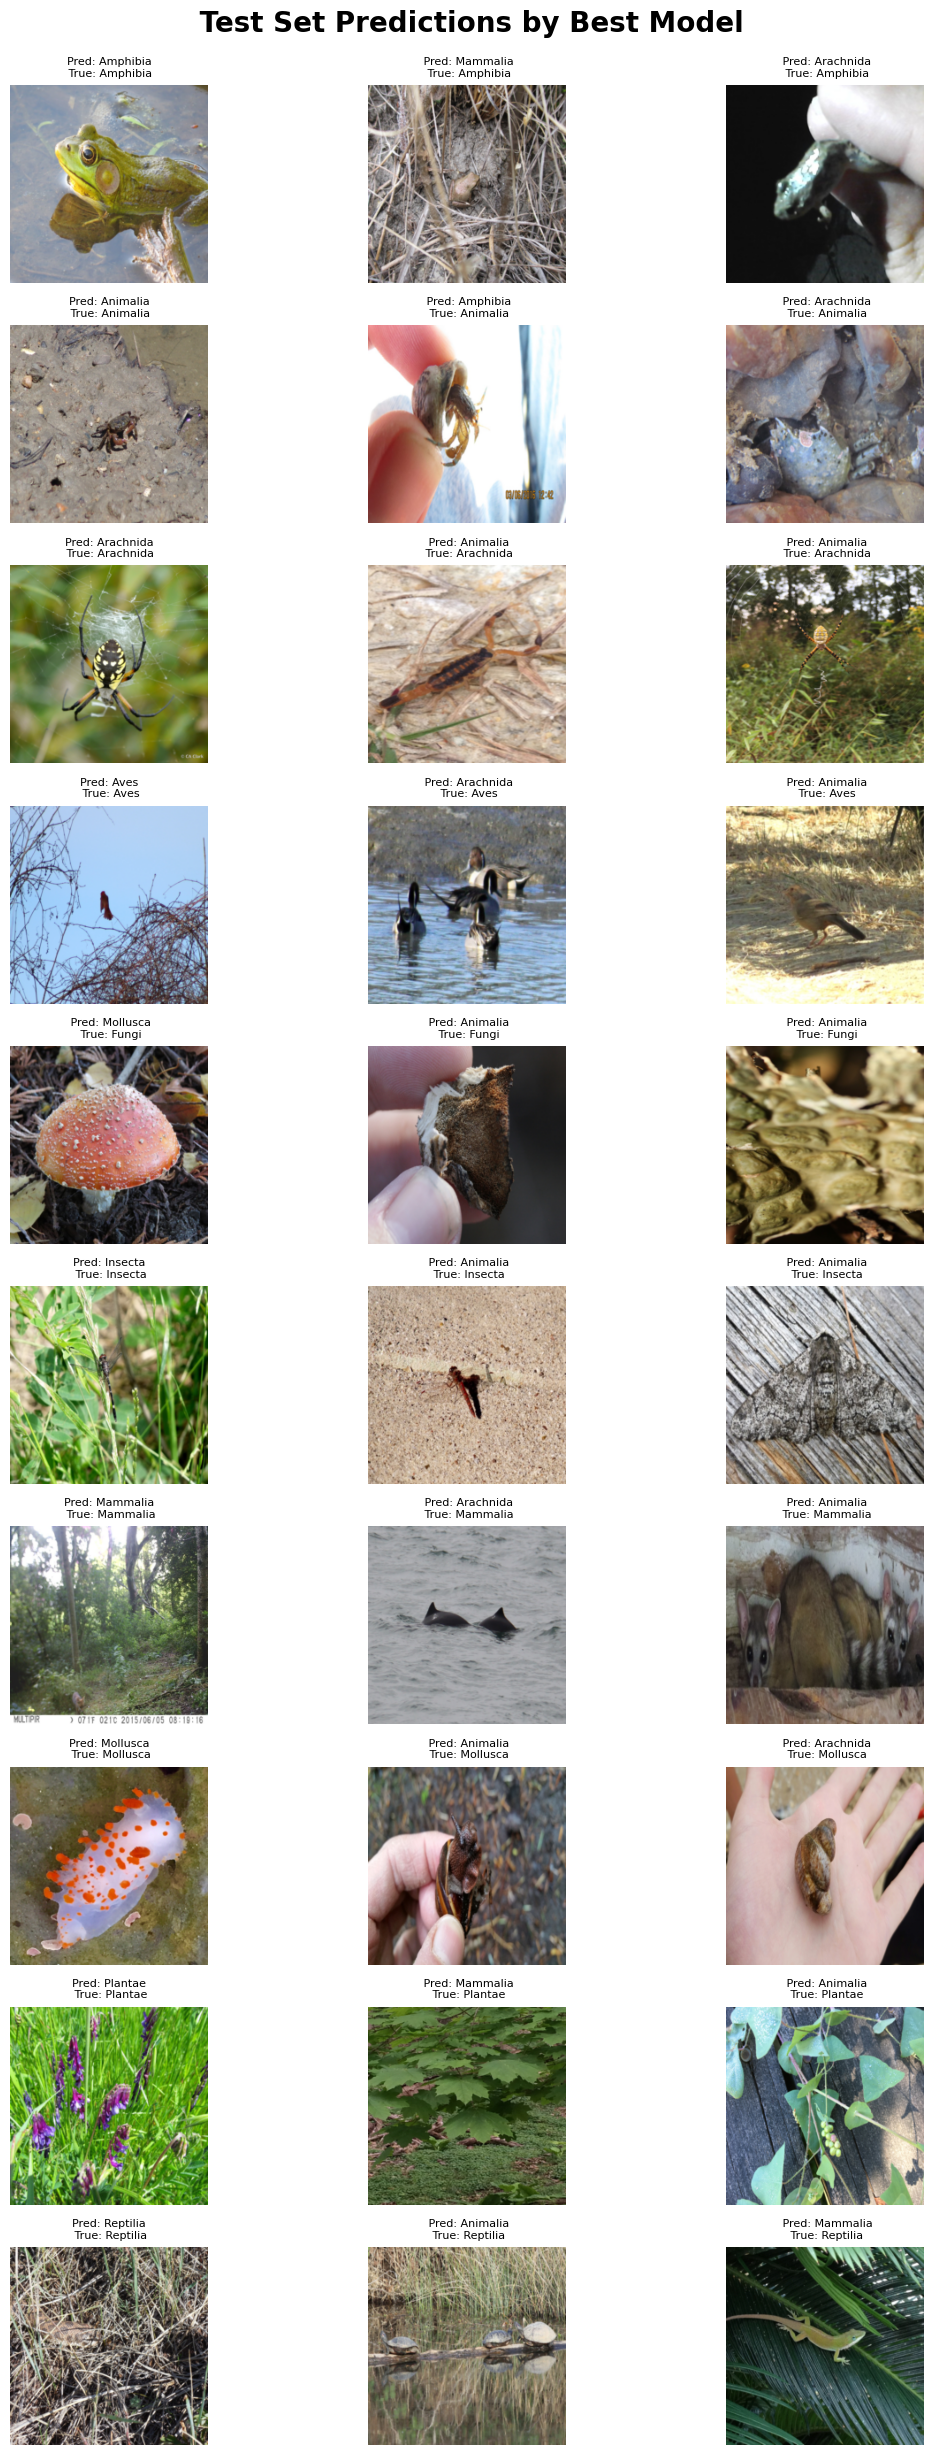

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Prepare a structure to store predictions
class_predictions = {i: {'correct': [], 'incorrect': []} for i in range(10)}  # adjust if more classes

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        for img, pred, label in zip(images, preds, labels):
            img_cpu = img.cpu()
            if pred == label:
                class_predictions[label.item()]['correct'].append((img_cpu, pred.item()))
            else:
                class_predictions[label.item()]['incorrect'].append((img_cpu, pred.item()))

# Plot 10x3 grid
fig, axes = plt.subplots(10, 3, figsize=(12, 25))
fig.suptitle(" Test Set Predictions by Best Model", fontsize=20, weight='bold')

for i in range(10):
    corrects = class_predictions[i]['correct']
    incorrects = class_predictions[i]['incorrect']
    plotted = 0

    # First column: correct if exists, else fallback to incorrect
    if corrects:
        img, pred = corrects[0]
        title = f"Pred: {class_names[pred]}\n True: {class_names[i]}"
    elif incorrects:
        img, pred = incorrects[0]
        title = f" Pred: {class_names[pred]}\n True: {class_names[i]}"
        incorrects = incorrects[1:]  # remove the one used
    else:
        img, pred = None, None

    if img is not None:
        axes[i, 0].imshow(np.clip(img.permute(1, 2, 0).numpy(), 0, 1))
        axes[i, 0].set_title(title, fontsize=8)
        axes[i, 0].axis("off")
        plotted += 1
    else:
        axes[i, 0].axis("off")

    # Next two columns: other incorrect predictions (if available)
    for j in range(2):
        if j < len(incorrects):
            img, pred = incorrects[j]
            axes[i, j + 1].imshow(np.clip(img.permute(1, 2, 0).numpy(), 0, 1))
            axes[i, j + 1].set_title(f" Pred: {class_names[pred]}\n True: {class_names[i]}", fontsize=8)
            axes[i, j + 1].axis("off")
        else:
            axes[i, j + 1].axis("off")

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()
